Ingesting Data...
Simulating 1000 franchises over 5 years (410 games)...


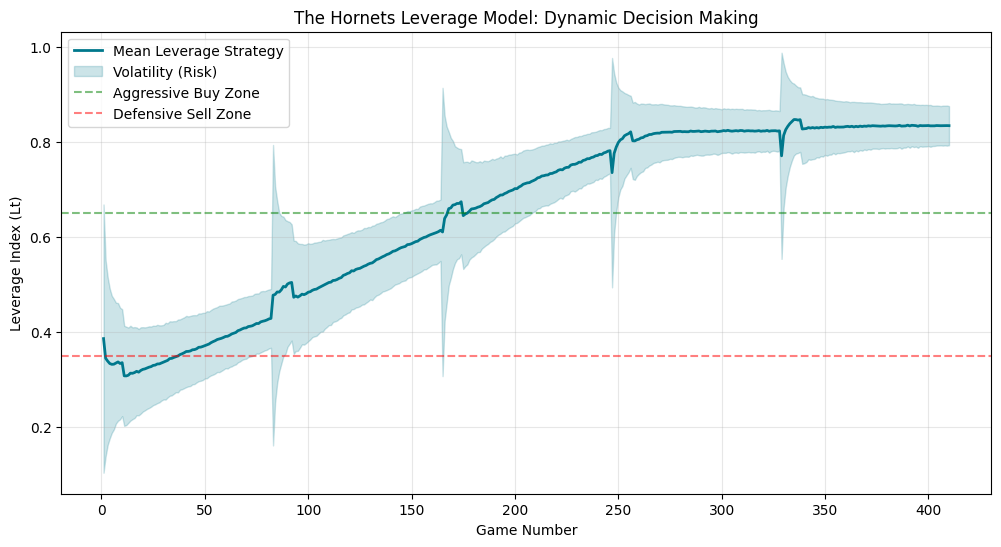

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# --- 1. CONFIGURATION & CONSTANTS ---

NUM_SIMULATIONS = 1000  # Adjust to 10000 for final high-res run
GAMES_IN_SEASON = 82
MY_TEAM = 'CHO'         # Charlotte Hornets ID

# Financial Constants (Millions USD)
FINANCIALS = {
    'baseline_revenue': 328,
    'initial_debt': 304,
    'max_debt_capacity': 475,
    'safe_debt_threshold': 325
}

# Model Weights
WEIGHTS = {
    'lev_perf': 5.0,         # Impact of Winning on Leverage
    'lev_fin': 3.0,          # Impact of Money on Leverage
    'lev_risk': -4.0,        # Impact of Risk on Leverage
    'revenue_win_factor': 0.3, 
    'revenue_star_factor': 0.5
}

# --- NEW CONSTANTS FOR ADVANCED MODELING ---
ADVANCED_PARAMS = {
    'operating_expense_per_game': 3.0, # Pi_t (Salary + Venue ops)
    'debt_service_per_game': 0.5,      # DS_t (Interest payments)
    'lookback_window': 5,              # m (For momentum)
    'volatility_window': 10,           # Window to measure risk
    
    # Weights for the Sub-Indices
    # Finance Weights (Must sum to approx 1 or be normalized)
    'w_fin_debt': 0.4,
    'w_fin_cost': 0.4,
    'w_fin_mom': 0.2,
    
    # Risk Weights (gamma)
    'gamma_i': 0.4, # Injury
    'gamma_r': 0.2, # Rev Volatility
    'gamma_d': 0.4  # Leverage Risk
}

# --- 2. DATA INGESTION & PREPARATION ---

def initialize_league_data(csv_file_path):
    """
    Parses CSV to build full rosters with Skill, Weight, and Injury Risk.
    """
    df = pd.read_csv(csv_file_path)
    df = df[df['Player'] != 'League Average']

    # A. Consolidate Traded Players
    # Use total stats (2TM) but assign to current team (last stint)
    final_rows = []
    for player, group in df.groupby('Player'):
        if len(group) > 1 and group['Team'].isin(['2TM', '3TM', '4TM']).any():
            stats_row = group[group['Team'].isin(['2TM', '3TM', '4TM'])].iloc[0].copy()
            current_team = group[~group['Team'].isin(['2TM', '3TM', '4TM'])].iloc[-1]['Team']
            stats_row['Team'] = current_team
            final_rows.append(stats_row)
        else:
            final_rows.append(group.iloc[0])
    
    df_clean = pd.DataFrame(final_rows)

    # B. Calculate Metrics
    # MPG (Minutes Per Game)
    df_clean['MPG'] = df_clean['MP'] / df_clean['G']
    
    # Weight: Share of 48-minute game
    df_clean['Weight'] = df_clean['MPG'] / 48.0
    
    # Skill: Normalized PER
    valid_players = df_clean[df_clean['MP'] > 50]
    min_per, max_per = valid_players['PER'].min(), valid_players['PER'].max()
    
    def get_skill(per):
        return (per - min_per) / (max_per - min_per)
    
    # Injury Risk: Baseline 50 games = Healthy
    def get_injury_risk(g):
        return max(0.0, 1.0 - (g / 50.0))

    df_clean['Skill_Norm'] = df_clean['PER'].apply(get_skill)
    df_clean['Injury_Risk'] = df_clean['G'].apply(get_injury_risk)

    # C. Build Roster Dictionary
    # Structure: { 'CHO': [ {player_data}, ... ], 'BOS': [...] }
    all_rosters = {}
    
    for team in df_clean['Team'].unique():
        # Get team roster sorted by importance (Weight)
        roster_df = df_clean[df_clean['Team'] == team].sort_values('Weight', ascending=False)
        
        team_list = []
        for _, row in roster_df.iterrows():
            player = {
                'name': row['Player'],
                'skill': [row['Skill_Norm']],
                'weight': row['Weight'],
                'injury_prob': row['Injury_Risk'],
                'is_star': row['PER'] > 18.0 and row['MPG'] > 25.0
            }
            team_list.append(player)
        
        all_rosters[team] = team_list # Keep full roster, logic will pick rotation

    return all_rosters

# --- 3. HELPER FUNCTIONS ---

def get_game_strength(roster, top_n=10):
    """
    Simulates a single game's roster strength.
    Iterates through top N players. Rolls dice for injury.
    Returns: Weighted Strength Score, Number of Stars Active, Injury Count
    """
    strength_sum = 0
    weight_sum = 0
    stars_active = 0
    starters_injured = 0
    
    # Limit to rotation size (Top 10 players usually play)
    rotation = roster[:top_n]
    
    for i, p in enumerate(rotation):
        # Bernoulli Trial: Is player healthy today?
        is_healthy = np.random.random() > p['injury_prob']
        
        if is_healthy:
            contribution = p['skill'][-1] * p['weight']
            strength_sum += contribution
            weight_sum += p['weight']
            if p['is_star']: stars_active += 1
        else:
            # Count starter injury if it's a key player (Top 5)
            if i < 5: starters_injured += 1
        lower = 0.8 * p['skill'][0]
        upper = 1.2 * p['skill'][0]
        if p['skill'][-1] >= lower and p['skill'][-1] <= upper:
            p['skill'].append(p['skill'][-1] + np.random.uniform(-0.05,0.05))
        else:
            if p['skill'][-1] > upper: p['skill'].append(upper)
            if p['skill'][-1] < lower: p['skill'].append(lower)
            
    # Normalize strength by the total weight of minutes filled
    final_strength = strength_sum / weight_sum if weight_sum > 0 else 0
    return final_strength, stars_active, starters_injured

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# --- 4. MAIN SIMULATION LOOP ---

def run_simulation(csv_path):
    
    # 1. Initialize Data
    print("Ingesting Data...")
    all_rosters = initialize_league_data(csv_path)
    
    # Get list of opponents (All teams except Charlotte)
    opponents = list(all_rosters.keys())
    if MY_TEAM in opponents: opponents.remove(MY_TEAM)
    
    # Storage
    results_leverage = np.zeros((NUM_SIMULATIONS, GAMES_IN_SEASON))
    results_wins = np.zeros(NUM_SIMULATIONS)
    
    print(f"Simulating {NUM_SIMULATIONS} seasons...")
    
    for sim in range(NUM_SIMULATIONS):
        
        active_rosters = copy.deepcopy(all_rosters)

        # Create Schedule: Random 82 games against league opponents
        schedule = np.random.choice(opponents, GAMES_IN_SEASON)
        
        # Reset State
        wins = 0
        revenue_history = [] # To track momentum and volatility
        current_debt = FINANCIALS['initial_debt']
        
        season_lev = []
        
        for t, opp_team in enumerate(schedule):
            
            # A. Calculate Dynamic Team Strengths
            # 1. My Team (Charlotte)
            my_strength, my_stars, my_injuries = get_game_strength(active_rosters[MY_TEAM])
            
            # 2. Opponent Team (Specific Opponent Roster)
            opp_strength, _, _ = get_game_strength(active_rosters[opp_team])
            
            # B. Determine Outcome (Logistic Regression)
            diff = my_strength - opp_strength
            # Logistic Prob: P(Win) = 1 / (1 + e^-(b0 + b1*diff))
            # b1=15.0 makes the curve steep enough for NBA talent gaps
            # b0=0.087 if home court advantage is considered, .5 probability
            win_prob = 1 / (1 + np.exp(-(0.087*np.random.choice([0,1]) + 15.0 * diff)))
            win_prob += np.random.normal(-0.05, 0.05) # Random Noise
            
            # Simulation (Bernoulli)
            is_win = 1 if np.random.random() < win_prob else 0
            wins += is_win
            
            # C. Update Finance

            # Calculate per-game baseline revenue (TV deals, fixed sponsors)
            base_game_rev = FINANCIALS['baseline_revenue'] / GAMES_IN_SEASON
            game_rev = base_game_rev # Start with the base (~$4M)
            if is_win: game_rev += WEIGHTS['revenue_win_factor']
            if my_stars > 0: game_rev += (WEIGHTS['revenue_star_factor'] * my_stars)
            game_rev *= np.random.uniform(0.9, 1.1) # Add random noise to revenue (ticket sales fluctuations)
            revenue_history.append(game_rev)

            # Debt Sub-Index (Solvency)
            # Logic: Revenue pays for Ops + Debt Service. Surplus pays down principal. Deficit increases debt.
            costs = ADVANCED_PARAMS['operating_expense_per_game'] + ADVANCED_PARAMS['debt_service_per_game']
            cash_flow = game_rev - costs
            current_debt -= cash_flow
            
            F_debt = 1.0 - (current_debt / FINANCIALS['max_debt_capacity'])
            F_debt = np.clip(F_debt, 0, 1)
            
            # Cost Coverage Sub-Index (Liquidity)
            # Ft_l = min(1, CF / (Pi + DS))
            # Here CF is Gross Revenue before costs
            coverage_ratio = game_rev / costs
            F_cost = min(1.0, coverage_ratio)
            
            # Revenue Momentum Sub-Index
            # Ft_r = (Rev_t - Rev_{t-m}) / Rev_{t-m}
            m = ADVANCED_PARAMS['lookback_window']
            if t >= m:
                past_rev = revenue_history[t-m]
                # Normalize: A 20% jump is great (1.0), a drop is bad (0.0)
                momentum = (game_rev - past_rev) / past_rev
                # Map momentum (-0.5 to +0.5) to (0 to 1)
                F_mom = sigmoid(5 * momentum) 
            else:
                F_mom = 0.5 # Neutral start      
            
            # D. Update Risk

            # Injury Risk (Rt_i)
            # Sum of weights * risk for active roster
            # We already calculated my_injuries (count of injured starters)
            # Let's use the roster's inherent risk
            current_injury_load = 0
            for p in active_rosters[MY_TEAM][:10]:
                current_injury_load += (p['weight'] * p['injury_prob'])
            
            # Normalize: If load > 0.3, that's high risk
            R_inj = min(1.0, current_injury_load / 1.2)
            
            # Revenue Volatility (Rt_rev)
            # sigma / mean over window
            w = ADVANCED_PARAMS['volatility_window']
            if t >= w:
                recent_revs = revenue_history[-w:]
                sigma = np.std(recent_revs)
                mu = np.mean(recent_revs)
                # Coefficient of Variation
                cv = sigma / mu if mu > 0 else 1.0
                # Normalize: CV > 0.2 is high risk
                R_rev = min(1.0, cv / 0.2)
            else:
                R_rev = 0.2 # Low initial volatility assumption
                
            # Leverage Risk (Rt_lev)
            # Dt / D_safe
            R_lev = current_debt / FINANCIALS['safe_debt_threshold']
            R_lev = np.clip(R_lev, 0, 1) # Cap at 1 if over threshold


            # E. Calculate Sub-Indices
            
            # Performance (Pt): Weighted mix of Record and Current Roster Strength
            win_pct = wins / (t + 1)
            P_t = (0.6 * win_pct) + (0.4 * my_strength)
            
            # Finance (Ft)
            F_t = (ADVANCED_PARAMS['w_fin_debt'] * F_debt) + \
                  (ADVANCED_PARAMS['w_fin_cost'] * F_cost) + \
                  (ADVANCED_PARAMS['w_fin_mom'] * F_mom)
            
            # Risk (Rt): Injury Status + Financial Stress
            R_t = (ADVANCED_PARAMS['gamma_i'] * R_inj) + \
                  (ADVANCED_PARAMS['gamma_r'] * R_rev) + \
                  (ADVANCED_PARAMS['gamma_d'] * R_lev)
            
            # E. Leverage Index (Lt) - The Dependent Variable
            Z = (WEIGHTS['lev_perf'] * P_t) + \
                (WEIGHTS['lev_fin'] * F_t) + \
                (WEIGHTS['lev_risk'] * R_t) - 2.0
            
            L_t = sigmoid(Z)
            season_lev.append(L_t)

            if sim == 0 and t == 40:
                print(f"--- DEBUG PROBE (Game 40) ---")
                print(f"Perf (Pt): {P_t:.2f} (Contrib: {WEIGHTS['lev_perf']*P_t:.2f})")
                print(f"Fin  (Ft): {F_t:.2f} (Contrib: {WEIGHTS['lev_fin']*F_t:.2f})")
                print(f"Risk (Rt): {R_t:.2f} (Contrib: {WEIGHTS['lev_risk']*R_t:.2f})")
                print(f"Z-Score:   {Z:.2f}")
                print(f"Leverage:  {L_t:.2f}")
                print(f"Current Debt: {current_debt:.1f}")
                print(f"Injury Load: {current_injury_load:.3f} / 1.2")
            
        results_leverage[sim, :] = season_lev
        results_wins[sim] = wins
        
        if sim % 100 == 0:
            print(f"Sim {sim}: Wins={wins}, Final Lev={L_t:.2f}")

    return results_leverage, results_wins

# --- 5. EXECUTION & PLOTTING ---

def run_simulation_multiyear(csv_path, num_years=5):
    print("Ingesting Data...")
    all_rosters = initialize_league_data(csv_path)
    
    opponents = list(all_rosters.keys())
    if MY_TEAM in opponents: opponents.remove(MY_TEAM)
    
    # MULTI-YEAR UPGRADE: Total games = 82 * num_years
    TOTAL_GAMES = GAMES_IN_SEASON * num_years
    results_leverage = np.zeros((NUM_SIMULATIONS, TOTAL_GAMES))
    
    print(f"Simulating {NUM_SIMULATIONS} franchises over {num_years} years ({TOTAL_GAMES} games)...")
    
    for sim in range(NUM_SIMULATIONS):
        
        active_rosters = copy.deepcopy(all_rosters)
        
        # MULTI-YEAR UPGRADE: Debt persists across seasons
        current_debt = FINANCIALS['initial_debt']
        
        # Track leverage across all years continuously
        franchise_lev_history = []
        
        # --- SEASON LOOP (Year 0 to 4) ---
        for year in range(num_years):
            
            # MULTI-YEAR UPGRADE: Financial Inflation (5% per year)
            inflation_factor = 1.05 ** year
            year_baseline_rev = FINANCIALS['baseline_revenue'] * inflation_factor
            year_op_cost = ADVANCED_PARAMS['operating_expense_per_game'] * inflation_factor
            
            # Create Schedule
            schedule = np.random.choice(opponents, GAMES_IN_SEASON)
            
            # Reset Season-Specific Counters
            wins = 0
            revenue_history = [] 
            
            for t, opp_team in enumerate(schedule):
                
                # ... [Game Logic is mostly same, but uses year_baseline_rev] ...
                
                # 1. Strengths
                my_strength, my_stars, my_injuries = get_game_strength(active_rosters[MY_TEAM])
                opp_strength, _, _ = get_game_strength(active_rosters[opp_team])
                
                # 2. Outcome
                diff = my_strength - opp_strength
                win_prob = 1 / (1 + np.exp(-(0.087 + 15.0 * diff)))
                win_prob = np.clip(win_prob + np.random.normal(0, 0.05), 0, 1)
                is_win = 1 if np.random.random() < win_prob else 0
                wins += is_win
                
                # 3. Finance (Adjusted for Inflation)
                base_game_rev = year_baseline_rev / GAMES_IN_SEASON
                game_rev = base_game_rev
                if is_win: game_rev += (WEIGHTS['revenue_win_factor'] * inflation_factor)
                if my_stars > 0: game_rev += (WEIGHTS['revenue_star_factor'] * my_stars * inflation_factor)
                game_rev *= np.random.uniform(0.9, 1.1)
                revenue_history.append(game_rev)

                # Costs & Debt Update
                costs = year_op_cost + ADVANCED_PARAMS['debt_service_per_game']
                cash_flow = game_rev - costs
                current_debt -= cash_flow
                
                # 4. Indices Calculation
                F_debt = np.clip(1.0 - (current_debt / FINANCIALS['max_debt_capacity']), 0, 1)
                F_cost = min(1.0, game_rev / costs)
                
                # Momentum
                m = ADVANCED_PARAMS['lookback_window']
                if t >= m:
                    past_rev = revenue_history[t-m]
                    momentum = (game_rev - past_rev) / past_rev
                    F_mom = sigmoid(5 * momentum) 
                else:
                    F_mom = 0.5
                
                # Risk Components
                current_injury_load = sum([p['weight'] * p['injury_prob'] for p in active_rosters[MY_TEAM][:10]])
                R_inj = min(1.0, current_injury_load / 1.2) # Calibrated Threshold
                
                w = ADVANCED_PARAMS['volatility_window']
                if t >= w:
                    recent = revenue_history[-w:]
                    R_rev = min(1.0, (np.std(recent)/np.mean(recent))/0.2)
                else:
                    R_rev = 0.2
                
                R_lev = np.clip(current_debt / FINANCIALS['safe_debt_threshold'], 0, 1)

                # Aggregation
                win_pct = wins / (t + 1)
                P_t = (0.6 * win_pct) + (0.4 * my_strength)
                
                F_t = (ADVANCED_PARAMS['w_fin_debt'] * F_debt) + \
                      (ADVANCED_PARAMS['w_fin_cost'] * F_cost) + \
                      (ADVANCED_PARAMS['w_fin_mom'] * F_mom)
                
                R_t = (ADVANCED_PARAMS['gamma_i'] * R_inj) + \
                      (ADVANCED_PARAMS['gamma_r'] * R_rev) + \
                      (ADVANCED_PARAMS['gamma_d'] * R_lev)
                
                Z = (WEIGHTS['lev_perf'] * P_t) + \
                    (WEIGHTS['lev_fin'] * F_t) + \
                    (WEIGHTS['lev_risk'] * R_t) - 2.0
                
                L_t = sigmoid(Z)
                franchise_lev_history.append(L_t)

            # --- END OF SEASON: ROSTER EVOLUTION ---
            # MULTI-YEAR UPGRADE: Players age and improve/decline
            for team_name in active_rosters:
                for p in active_rosters[team_name]:
                    # Simple Aging Curve Logic
                    # Young players (skill < 0.6) improve. Old players decline.
                    # Add random variance
                    if p['skill'][0] < 0.6: 
                        improvement = np.random.uniform(0.0, 0.05) # Growth
                    elif p['skill'][0] > 0.8:
                        improvement = np.random.uniform(-0.05, 0.0) # Decline
                    else:
                        improvement = np.random.uniform(-0.02, 0.02) # Peak Plateau
                    
                    # Apply update
                    new_skill = max(0.1, min(0.99, p['skill'][0] + improvement))
                    p['skill'] = [new_skill] # Update stored skill

        # Store multi-year history for this simulation
        results_leverage[sim, :] = franchise_lev_history

    return results_leverage

# Make sure 'season-stats.csv' is in your folder
lev_data = run_simulation_multiyear('data/season-stats.csv', num_years=5)

# --- PLOTTING CODE (Run after simulation) ---
mean_lev = np.mean(lev_data, axis=0)
std_lev = np.std(lev_data, axis=0)
x = np.arange(1, mean_lev.shape[0] + 1)

plt.figure(figsize=(12, 6))
plt.plot(x, mean_lev, color='#00788C', linewidth=2, label='Mean Leverage Strategy') # Hornets Teal
plt.fill_between(x, mean_lev - std_lev, mean_lev + std_lev, color='#00788C', alpha=0.2, label='Volatility (Risk)')

plt.axhline(0.65, color='green', linestyle='--', alpha=0.5, label='Aggressive Buy Zone')
plt.axhline(0.35, color='red', linestyle='--', alpha=0.5, label='Defensive Sell Zone')

plt.title('The Hornets Leverage Model: Dynamic Decision Making')
plt.xlabel('Game Number')
plt.ylabel('Leverage Index (Lt)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# print(f"Projected Mean Wins: {np.mean(win_data)/5:.1f}")